# SUMMARY
This notebook generates synthetic images based on `extra_approved_InChIs.csv` using RDKit. The code is hevaliy based on [this Kaggle notebook](https://www.kaggle.com/tuckerarrants/inchi-allowed-external-data).

In [ ]:
##### OUTPUT IMAGE PATH

OUTPUT_DIR = '../input/extra/'

# PREPARATIONS

In [1]:
##### PACKAGES

!conda install -y -c rdkit rdkit

import numpy as np
import pandas as pd
import re
from tqdm.auto import tqdm
tqdm.pandas()

import torch
from torch.utils.data import Dataset
import cv2

import rdkit.Chem as Chem

from matplotlib import pyplot as plt
%matplotlib inline

import os
import pickle

In [ ]:
##### MODULES

sys.path.append('../codes')
from tokenizer import Tokenizer
from preprocessing import split_form, split_form2, l_split, get_atom_counts, get_train_file_path

# DATA PREP

In [5]:
##### IMPORT INCHI FORMULAS

train = pd.read_pickle('../input/train2.pkl')
train['file_path'] = train['image_id'].apply(get_train_file_path)
allowed_inchi = pd.read_csv('../input/extra_approved_InChIs.csv')
print(allowed_inchi.shape)
allowed_inchi.head()

(9998711, 1)


,InChI
0,InChI=1S/C13H10Cl4O4/c1-20-13(21-2)11(16)5-6-8...
1,InChI=1S/C23H32O6Si/c1-20(2)25-15-19(27-20)22(...
2,InChI=1S/C24H16N4O3/c29-21-19-20(14-8-2-1-3-9-...
3,InChI=1S/C20H26N2O5/c1-9-14-11-7-13-19(8-21-3)...
4,InChI=1S/C14H12BrN/c15-8-3-1-7(2-4-8)12-9-5-10...


In [6]:
##### PREPARE INCHI FORMULAS: 1

allowed_inchi['InChI_1'] = allowed_inchi['InChI'].progress_apply(lambda x: x.split('/')[1])
print('...')
allowed_inchi['InChI_text'] = allowed_inchi['InChI_1'].progress_apply(split_form) + ' ' + \
                        allowed_inchi['InChI'].apply(lambda x: '/'.join(x.split('/')[2:])).progress_apply(split_form2).values

  0%|          | 0/9998711 [00:00<?, ?it/s]

...


  0%|          | 0/9998711 [00:00<?, ?it/s]

  0%|          | 0/9998711 [00:00<?, ?it/s]

In [7]:
##### PREPARE INCHI FORMULAS: 2

train, allowed_inchi = get_atom_counts(train), get_atom_counts(allowed_inchi)
allowed_inchi.head()

  0%|          | 0/2424186 [00:00<?, ?it/s]

  0%|          | 0/9998711 [00:00<?, ?it/s]

,InChI,InChI_1,InChI_text,B,Br,C,Cl,F,H,I,N,O,P,S,Si
0,InChI=1S/C13H10Cl4O4/c1-20-13(21-2)11(16)5-6-8...,C13H10Cl4O4,C 13 H 10 Cl 4 O 4 /c 1 - 20 - 13 ( 21 - 2 ) 1...,0,0,13,4,0,10,0,0,4,0,0,0
1,InChI=1S/C23H32O6Si/c1-20(2)25-15-19(27-20)22(...,C23H32O6Si,C 23 H 32 O 6 Si /c 1 - 20 ( 2 ) 25 - 15 - 19 ...,0,0,23,0,0,32,0,0,6,0,0,1
2,InChI=1S/C24H16N4O3/c29-21-19-20(14-8-2-1-3-9-...,C24H16N4O3,C 24 H 16 N 4 O 3 /c 29 - 21 - 19 - 20 ( 14 - ...,0,0,24,0,0,16,0,4,3,0,0,0
3,InChI=1S/C20H26N2O5/c1-9-14-11-7-13-19(8-21-3)...,C20H26N2O5,C 20 H 26 N 2 O 5 /c 1 - 9 - 14 - 11 - 7 - 13 ...,0,0,20,0,0,26,0,2,5,0,0,0
4,InChI=1S/C14H12BrN/c15-8-3-1-7(2-4-8)12-9-5-10...,C14H12BrN,C 14 H 12 Br N /c 15 - 8 - 3 - 1 - 7 ( 2 - 4 -...,0,1,14,0,0,12,0,1,0,0,0,0


In [8]:
##### CONVERT TO TOKENS

# import tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(allowed_inchi['InChI_text'].values)
print('Saved tokenizer')

# preprocess molecules
lengths = []
for text in tqdm(allowed_inchi['InChI_text'].values, total=len(allowed_inchi)):
    seq = tokenizer.text_to_sequence(text)
    length = len(seq) - 2
    lengths.append(length)
allowed_inchi['InChI_length'] = lengths
allowed_inchi.to_pickle('allowed_inchi_processed.pkl')

Saved tokenizer


  0%|          | 0/9998711 [00:00<?, ?it/s]

# IMAGE GENERATION

In [12]:
##### HELPER FUNCTIONS

def sp_noise(image):
    #https://gist.github.com/lucaswiman/1e877a164a69f78694f845eab45c381a
    output = image.copy()
    if len(image.shape) == 2:
        black = 0
        white = 255            
    else:
        colorspace = image.shape[2]
        if colorspace == 3:  # RGB
            black = np.array([0, 0, 0], dtype='uint8')
            white = np.array([255, 255, 255], dtype='uint8')
        else:  # RGBA
            black = np.array([0, 0, 0, 255], dtype='uint8')
            white = np.array([255, 255, 255, 255], dtype='uint8')
    probs = np.random.random(image.shape[:2])
    image[probs < .00015] = black
    image[probs > .85] = white
    return image

def noisy_inchi(inchi, inchi_path, add_noise=True, crop_and_pad=True):
    
    mol = Chem.MolFromInchi(inchi)
    d   = Chem.Draw.rdMolDraw2D.MolDraw2DCairo(300, 300)
    
    # https://www.kaggle.com/stainsby/improved-synthetic-data-for-bms-competition-v3
    Chem.rdDepictor.SetPreferCoordGen(True)
    d.drawOptions().maxFontSize=14
    d.drawOptions().multipleBondOffset=np.random.uniform(0.05, 0.2)
    d.drawOptions().useBWAtomPalette()
    d.drawOptions().bondLineWidth=1
    d.drawOptions().additionalAtomLabelPadding=np.random.uniform(0, .2)
    d.DrawMolecule(mol)
    d.FinishDrawing()
    d.WriteDrawingText(inchi_path) 
    
    if crop_and_pad:
        img = cv2.imread(inchi_path, cv2.IMREAD_GRAYSCALE)
        crop_rows = img[~np.all(img==255, axis=1), :]
        img = crop_rows[:, ~np.all(crop_rows==255, axis=0)]
        img = cv2.copyMakeBorder(img, 30, 30, 30, 30, cv2.BORDER_CONSTANT, value=255)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    else:
        img = cv2.imread(inchi_path)
    if add_noise:
        img = sp_noise(img)
        cv2.imwrite(inchi_path, img)
    return img

In [13]:
##### DATASET

class ExternalDataset(Dataset):
    def __init__(self, df, tokenizer, transform=None):
        super().__init__()
        self.df        = df
        self.tokenizer = tokenizer
        self.labels    = df['InChI_text'].values
        self.inchis    = df['InChI'].values
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        inchi = self.inchis[idx]
        image = noisy_inchi(inchi, inchi_path = f'{OUTPUT_DIR}/extra_{idx}.png')
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = self.labels[idx]
        label = self.tokenizer.text_to_sequence(label)
        label_length = len(label)
        label_length = torch.LongTensor([label_length])
        return image, torch.LongTensor(label), label_length

In [ ]:
##### GENERATE IMAGES

# preparations
allowed_inchi = allowed_inchi.sample(frac = 1).reset_index(drop =True)
ext_dataset = ExternalDataset(allowed_inchi, 
                              tokenizer, 
                              transform = None)

#  generation
for i in tqdm(range(3300000)):
    image, label, label_length = ext_dataset[i]

  0%|          | 0/400000 [00:00<?, ?it/s]

# EXPORT DATAFRAME

In [3]:
##### GET LIST OF IMAGE IDS

imgs = []
i    = 0

for file in os.scandir(OUTPUT_DIR):    
    i += 1
    imgs.append(file.name)
    if i % 100000 == 0:
        print(i)
            
imgs[0:10]

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000


['extra_483305.png',
 'extra_6195283.png',
 'extra_1121621.png',
 'extra_8090257.png',
 'extra_7204345.png',
 'extra_1079112.png',
 'extra_6157352.png',
 'extra_5234218.png',
 'extra_8052386.png',
 'extra_317069.png']

In [ ]:
##### PREPARE IDS

ids = [int(img.replace('extra_', '').replace('.png', '')) for img in imgs]
imgs = ['extra/' + img for img in imgs]

In [8]:
##### CONSTRUCT TABLE

df_extra = pd.read_csv('../input/ extra_approved_InChIs.csv')
df_extra = df_extra.iloc[ids].reset_index(drop = True)
df_extra['file_path'] = imgs
df_extra['image_id']  = ids
df_extra.head()

,InChI,file_path,image_id
0,InChI=1S/C14H20N4/c15-9-8-11-5-3-4-10-18(11)14...,extra/extra/extra_483305.png,483305
1,InChI=1S/C12H11BrFNO2S/c13-11-9(2-1-3-10(11)14...,extra/extra/extra_6195283.png,6195283
2,InChI=1S/C27H32N2O3/c1-4-5-17-28-27(31)21(3)29...,extra/extra/extra_1121621.png,1121621
3,InChI=1S/C14H18N6S/c15-13(16)11-8-10(5-6-17-11...,extra/extra/extra_8090257.png,8090257
4,InChI=1S/C13H11ClN6O/c1-9-12(6-17-19-7-15-16-8...,extra/extra/extra_7204345.png,7204345


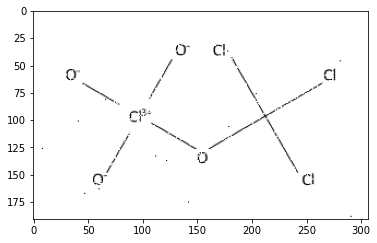

In [34]:
##### CHECK SAMPLE IMAGE

image = cv2.imread('../input/' + df_extra['file_path'][1], cv2.IMREAD_GRAYSCALE) 
plt.imshow(image, cmap = 'gray')

In [25]:
##### SORT BY LENGTH

df_extra['length'] = df_extra['InChI'].str.len()
df_extra = df_extra.sort_values('length', ascending = True).reset_index(drop = True)
del df_extra['image_id']

,InChI,file_path,length
0,"InChI=1S/CCl5OP/c2-1(3,4)8(5,6)7",extra/extra/extra_6229980.png,32
1,"InChI=1S/CCl4O4/c2-1(3,4)9-5(6,7)8",extra/extra/extra_9056364.png,34
2,"InChI=1S/CF5NS2/c2-9(3,4,5,6)7-1-8",extra/extra/extra_6202746.png,34
3,InChI=1S/CH3NO2/c1-4-2-3/h1H3/i1D3,extra/extra/extra_1137378.png,34
4,"InChI=1S/C4N4Si/c5-1-9(2-6,3-7)4-8",extra/extra/extra_5003698.png,34


In [9]:
##### EXPORT AS CSV

df_extra.to_csv('../input/extra.csv', index = False)
df_extra.shape

(3394423, 3)